In [1]:
from google.cloud import bigquery
from google.cloud import storage
import pandas as pd
import numpy as np

from scipy import stats
from dython.nominal import associations

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot  as plt
import math


In [ ]:
imported_to='2023-03-21'

In [2]:

isLastUpdate=True

IsNewData=False

label='severity_id'
labelName='severity_name'

bucket_name="gs://smart-ml-pongthorn"

threshold_x_sd = 3


removeCols=['id','updated_at','imported_at']

dateCols=['open_datetime','close_datetime','response_datetime','resolved_datetime']

numbericCols=['count_detail','open_to_close_hour','open_to_response_hour','response_to_resolved_hour']
#numbericCols=['count_detail','open_to_close_hour']

cateCols=['sla','product_type','brand','service_type','incident_type']


file_name="ML_Incident.csv"

In [3]:
def load_data_bq(sql:str):
 client_bq = bigquery.Client()
 query_result=client_bq.query(sql)
 df_all=query_result.to_dataframe()
 return df_all

In [4]:
sql_all=f"""
SELECT  id,
severity_id,severity_name,
count_detail,sla,
product_type,brand,service_type,incident_type,
open_datetime,  close_datetime, response_datetime,resolved_datetime, 
updated_at,imported_at
FROM `pongthorn.SMartDW.incident` WHERE imported_at< '{imported_to}'
order by imported_at
"""

file_name="ML_Incident.csv"
table_id = "pongthorn.SMartML.ml_incident"

print(f"Load Data to {table_id} and Save as csv file  to {file_name}")
    
if isLastUpdate:
    print("Load data from Bigquery")
    df_all=load_data_bq(sql_all)
    if len(df_all)>0:
     df_all.to_csv(f'data/{file_name}',index=False)
    else:
     print("No records from bigquery")   
else:
    print("Load data from Load CSV")
    df_all=pd.read_csv(f'data/{file_name}',parse_dates=dateCols)
    
df_all=df_all.drop_duplicates(subset=['id'],keep='first')

print("Update")
print(f"Max Last Import ={df_all['imported_at'].max()}   and  Update={df_all['updated_at'].max()}")



df_all.info()


Load Data to pongthorn.SMartML.ml_incident and Save as csv file  to ML_Incident.csv
Load data from Bigquery
Update
Max Last Import =2023-03-20 21:00:07.377573   and  Update=2023-03-20 18:04:16
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2316 entries, 0 to 2320
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2316 non-null   Int64         
 1   severity_id        2316 non-null   Int64         
 2   severity_name      2316 non-null   object        
 3   count_detail       2316 non-null   Int64         
 4   sla                2316 non-null   object        
 5   product_type       2316 non-null   object        
 6   brand              2316 non-null   object        
 7   service_type       2316 non-null   object        
 8   incident_type      2316 non-null   object        
 9   open_datetime      2316 non-null   datetime64[ns]
 10  close_datetime     2316 non-null   

# Manage Numberic Cols

In [5]:
start_end_list=[ ['open_datetime','close_datetime'],['open_datetime','response_datetime'],['response_datetime','resolved_datetime']]
listDiffDateDeltaCols=[]
listDiffHourCols=[]
for item  in  start_end_list:
   diff_str=f"{item[0]}_to_{item[1]}" 
   diff_str=diff_str.replace('_datetime','')  
   listDiffDateDeltaCols.append(diff_str)
   df_all[diff_str]=df_all[item[1]]-df_all[item[0]]
    
   diff_hour=f'{diff_str}_hour'
   listDiffHourCols.append(diff_hour)
   df_all[diff_hour] = df_all[diff_str].apply(lambda x:  x.total_seconds() / (60*60) if x is not np.nan else np.nan  )

# For Build Train Validation Test For Dev Phase 
xScoreDiffHourCols=[]
for col in listDiffHourCols:
  z_col=f"zscore_{col}"   
  df_all[z_col] = np.abs(stats.zscore(df_all[col]))   
  xScoreDiffHourCols.append(z_col)  
#remove oulier

for col in  xScoreDiffHourCols:
  df_all=df_all.query(f"{col}<@threshold_x_sd")

In [6]:
print(df_all.shape)
df_all.tail()

(2266, 24)


,id,severity_id,severity_name,count_detail,sla,product_type,brand,service_type,incident_type,open_datetime,...,imported_at,open_to_close,open_to_close_hour,open_to_response,open_to_response_hour,response_to_resolved,response_to_resolved_hour,zscore_open_to_close_hour,zscore_open_to_response_hour,zscore_response_to_resolved_hour
2316,2456,2,Major,1,24x7 6Hrs Resolution Time,Software,SAPB1,Request,Configuration Change,2023-01-19 14:36:00,...,2023-03-20 21:00:07.377573,32 days 01:05:00,769.083333,0 days 19:24:00,19.400000,31 days 05:41:00,749.683333,0.784066,0.378158,0.882014
2317,2457,2,Major,1,24x7 6Hrs Resolution Time,Software,SAPB1,Incident,Software,2023-01-19 08:31:00,...,2023-03-20 21:00:07.377573,0 days 00:12:00,0.200000,0 days 00:01:00,0.016667,0 days 00:11:00,0.183333,0.236435,0.101907,0.196729
2318,2458,2,Major,1,24x7 6Hrs Resolution Time,Software,SAPB1,Incident,Software,2023-01-19 13:05:00,...,2023-03-20 21:00:07.377573,0 days 00:12:00,0.200000,0 days 00:01:00,0.016667,0 days 00:11:00,0.183333,0.236435,0.101907,0.196729
2319,2459,2,Major,1,24x7 6Hrs Resolution Time,Software,SAPB1,Incident,Software,2023-01-19 14:13:00,...,2023-03-20 21:00:07.377573,0 days 00:07:00,0.116667,0 days 00:01:00,0.016667,0 days 00:06:00,0.100000,0.236546,0.101907,0.196849
2320,2455,2,Major,4,24x7 4Hrs Resolution Time,Server,HPE,Incident,Memory Failure,2023-03-19 22:01:00,...,2023-03-20 21:00:07.377573,0 days 04:12:00,4.200000,0 days 00:06:00,0.100000,0 days 04:06:00,4.100000,0.231126,0.099843,0.191092


# Find any rows  contain 0

In [7]:

# if>5%  remove column, else judge to remove 0 value 
# remove coundetail because mostly, there are few value 1,2 items
allRows=df_all.shape[0]
for col in numbericCols:
    zeroRows=len(df_all.query(f"{col}==0"))
    pctZeroHour=round(zeroRows/allRows*100,1)
    print(f"No. 0-hour row on {col} = {zeroRows}({pctZeroHour} %)")

No. 0-hour row on count_detail = 116(5.1 %)
No. 0-hour row on open_to_close_hour = 1(0.0 %)
No. 0-hour row on open_to_response_hour = 440(19.4 %)
No. 0-hour row on response_to_resolved_hour = 97(4.3 %)


# Bining Range

In [8]:
def explore_ranges_numberic_val(col,rangeList):
    print(col)
    rangeList.sort()
    return pd.cut(df_all[col],rangeList, right=True).value_counts()
range1= [0,24, 168, 360, 720,math.floor(df_all['open_to_close_hour'].max())]
print(explore_ranges_numberic_val('open_to_close_hour',range1))
print("=======================================================")

range2= [0,24, 168, 360, 720,math.floor(df_all['response_to_resolved_hour'].max())]
print(explore_ranges_numberic_val('response_to_resolved_hour',range2))
print("=======================================================")

range3= [0,4, 8, 12, 24,math.floor(df_all['open_to_response_hour'].max())]
print(explore_ranges_numberic_val('open_to_response_hour',range3))
print("=======================================================")

range4= [0,2, 4,math.floor(df_all['count_detail'].max())]
print(explore_ranges_numberic_val('count_detail',range4))
print("=======================================================")

open_to_close_hour
(0, 24]        1537
(24, 168]       457
(168, 360]      117
(720, 2349]      92
(360, 720]       61
Name: open_to_close_hour, dtype: int64
response_to_resolved_hour
(0, 24]        1603
(24, 168]       368
(168, 360]       92
(720, 2209]      61
(360, 720]       44
Name: response_to_resolved_hour, dtype: int64
open_to_response_hour
(0, 4]      1690
(12, 24]      46
(24, 96]      35
(4, 8]        32
(8, 12]       22
Name: open_to_response_hour, dtype: int64
count_detail
(0, 2]     1700
(2, 4]      271
(4, 35]     179
Name: count_detail, dtype: int64


In [10]:
print("remove some cate featurs that have dirty data")
numColsRemove=['open_to_response_hour','count_detail'] 
numbericCols=[x for x in numbericCols if x not in numColsRemove]   
numbericCols

remove some cate featurs that have dirty data


['open_to_close_hour', 'response_to_resolved_hour']

In [11]:
# remove response_to_resolved_hour ,it doesn't make any sense
df_all=df_all.query('response_to_resolved_hour!=0')

In [12]:
removeCols=removeCols+dateCols+xScoreDiffHourCols+listDiffDateDeltaCols+numColsRemove
df_all=df_all.drop(columns=removeCols)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2169 entries, 0 to 2320
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2169 non-null   Int64  
 1   severity_name              2169 non-null   object 
 2   sla                        2169 non-null   object 
 3   product_type               2169 non-null   object 
 4   brand                      2169 non-null   object 
 5   service_type               2169 non-null   object 
 6   incident_type              2169 non-null   object 
 7   open_to_close_hour         2169 non-null   float64
 8   response_to_resolved_hour  2169 non-null   float64
dtypes: Int64(1), float64(2), object(6)
memory usage: 171.6+ KB


In [13]:
df_all[numbericCols].describe()

,open_to_close_hour,response_to_resolved_hour
count,2169.000000,2169.000000
mean,98.214784,71.910934
std,270.750563,222.478360
min,0.083333,0.016667
25%,4.200000,3.000000
50%,8.750000,7.000000
75%,42.450000,25.833333
max,2348.183333,2209.150000


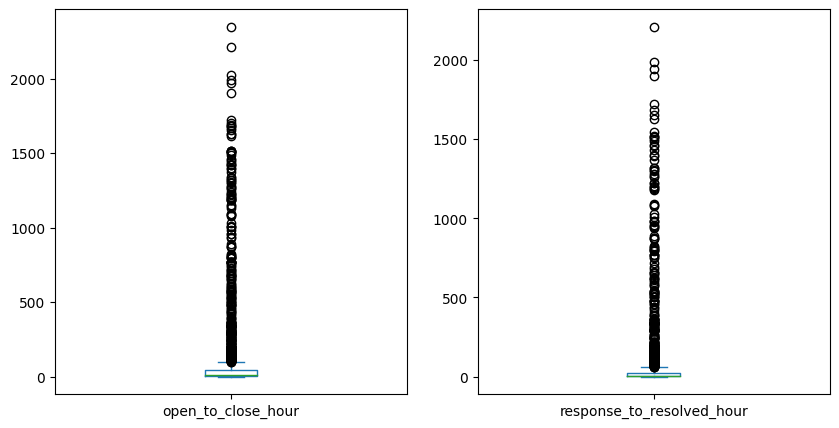

In [14]:
df_all[numbericCols].plot(kind='box',subplots=True,layout=(1,len(numbericCols)),sharex=False, sharey=False,figsize=(10,5))
plt.show()

array([[<Axes: xlabel='open_to_close_hour', ylabel='open_to_close_hour'>,
        <Axes: xlabel='response_to_resolved_hour', ylabel='open_to_close_hour'>],
       [<Axes: xlabel='open_to_close_hour', ylabel='response_to_resolved_hour'>,
        <Axes: xlabel='response_to_resolved_hour', ylabel='response_to_resolved_hour'>]],
      dtype=object)

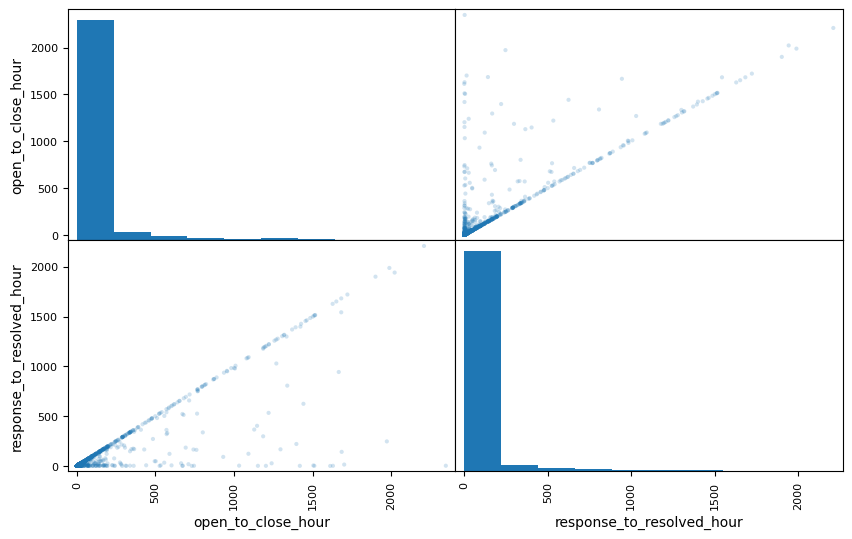

In [15]:
pd.plotting.scatter_matrix(df_all[numbericCols], alpha=0.2,figsize=(10,6))

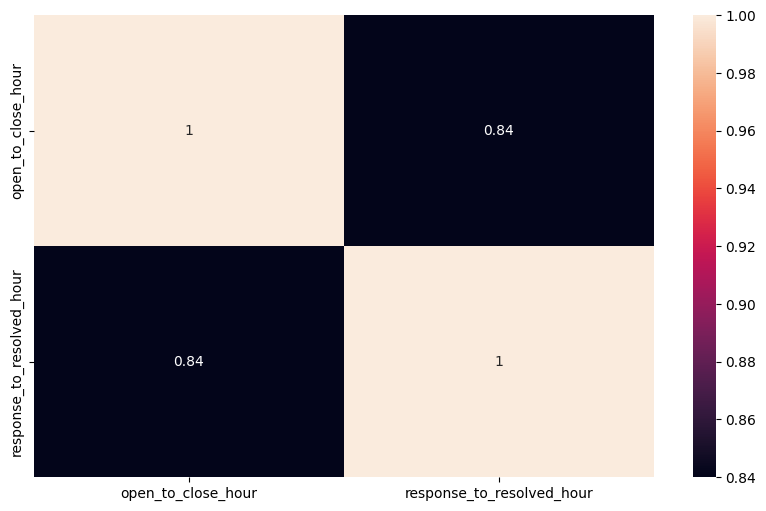

In [16]:
corr_df = df_all[numbericCols].corr ()  
corr_df = corr_df .round(2)

fig = plt.figure(figsize = (10, 6))
heatmap = sns. heatmap(corr_df, annot = True) 
plt. show ()

# Manage Categorical Cols

In [17]:
VBar=['brand','incident_type']
HBar=[ x for x in cateCols if x not in VBar]
HBar.insert(0,'severity_name')

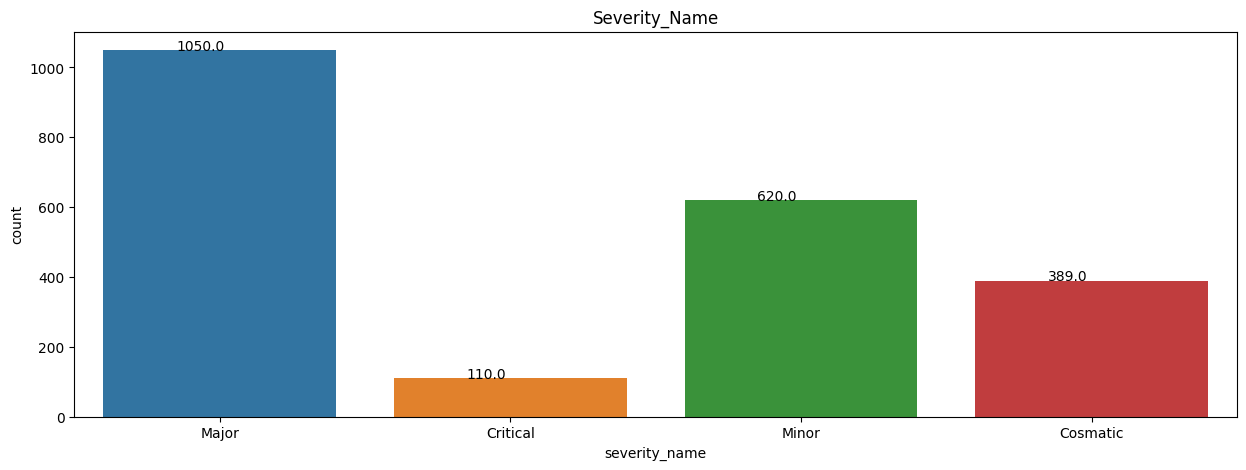

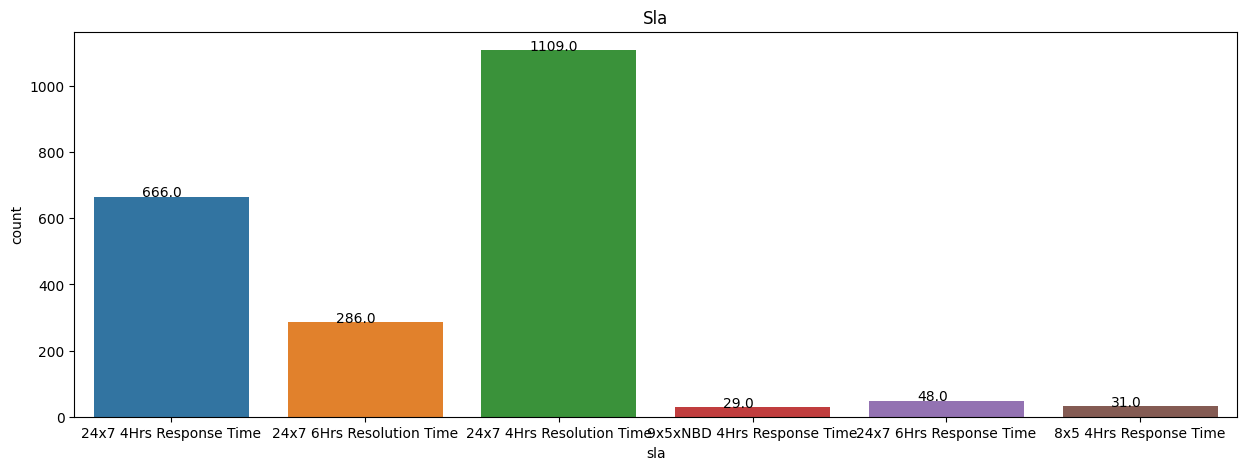

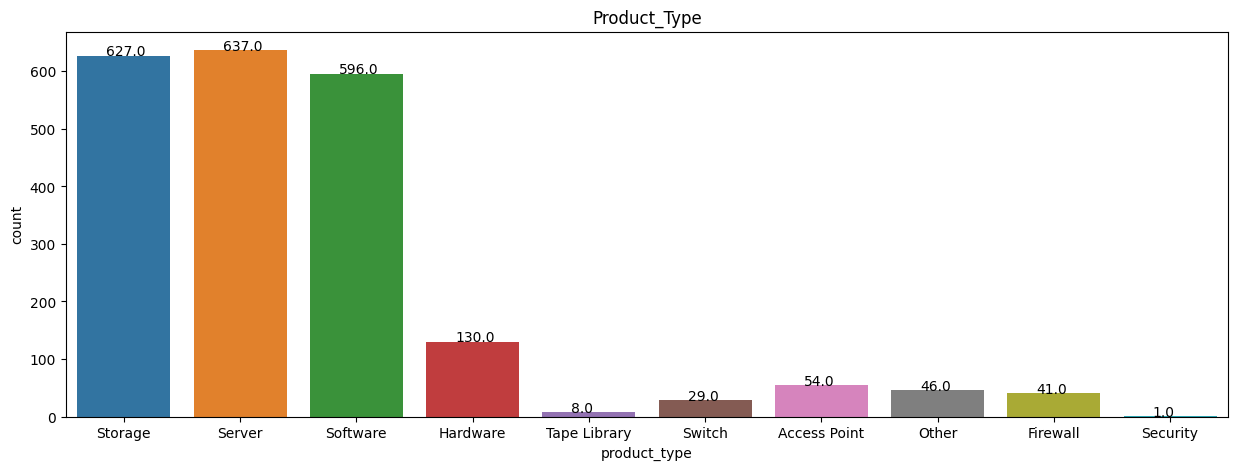

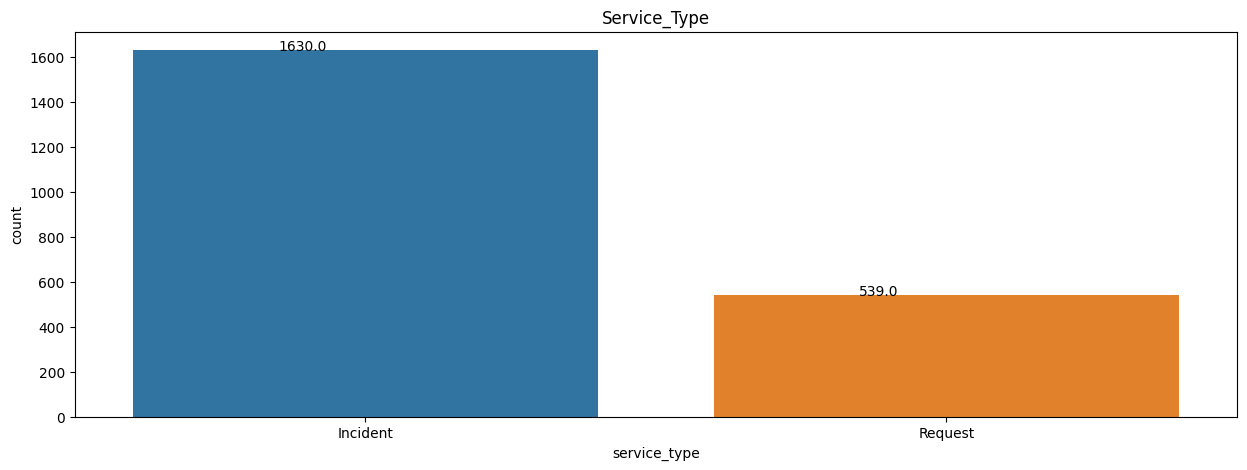

In [18]:
for col in HBar:
    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=col, data=df_all,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(col.title())
    plt.show()

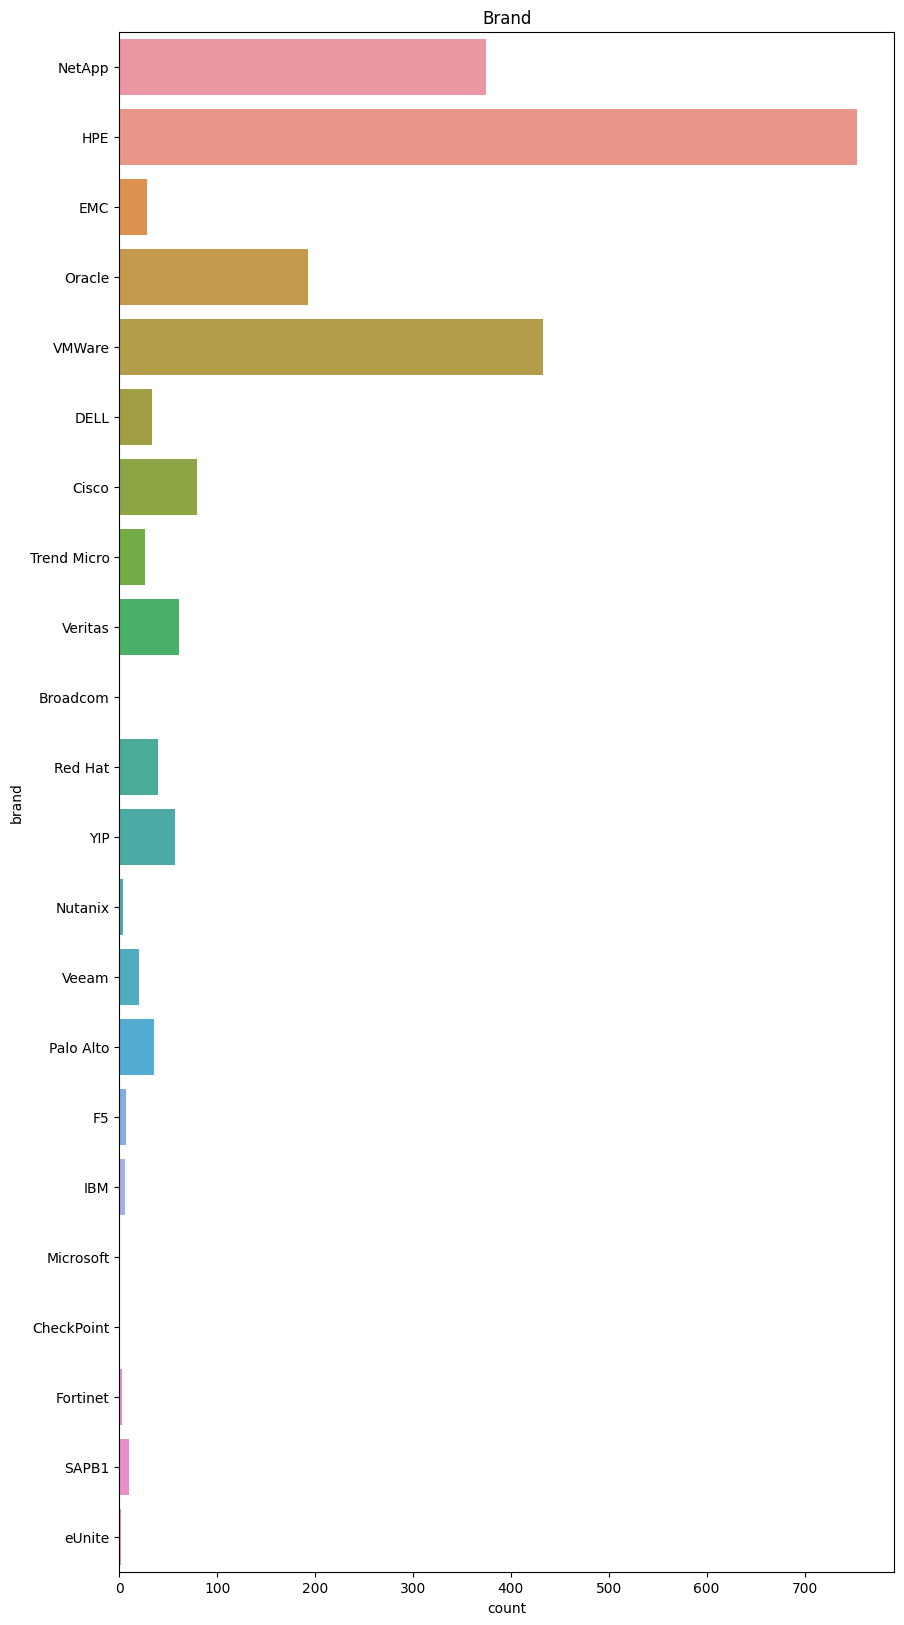

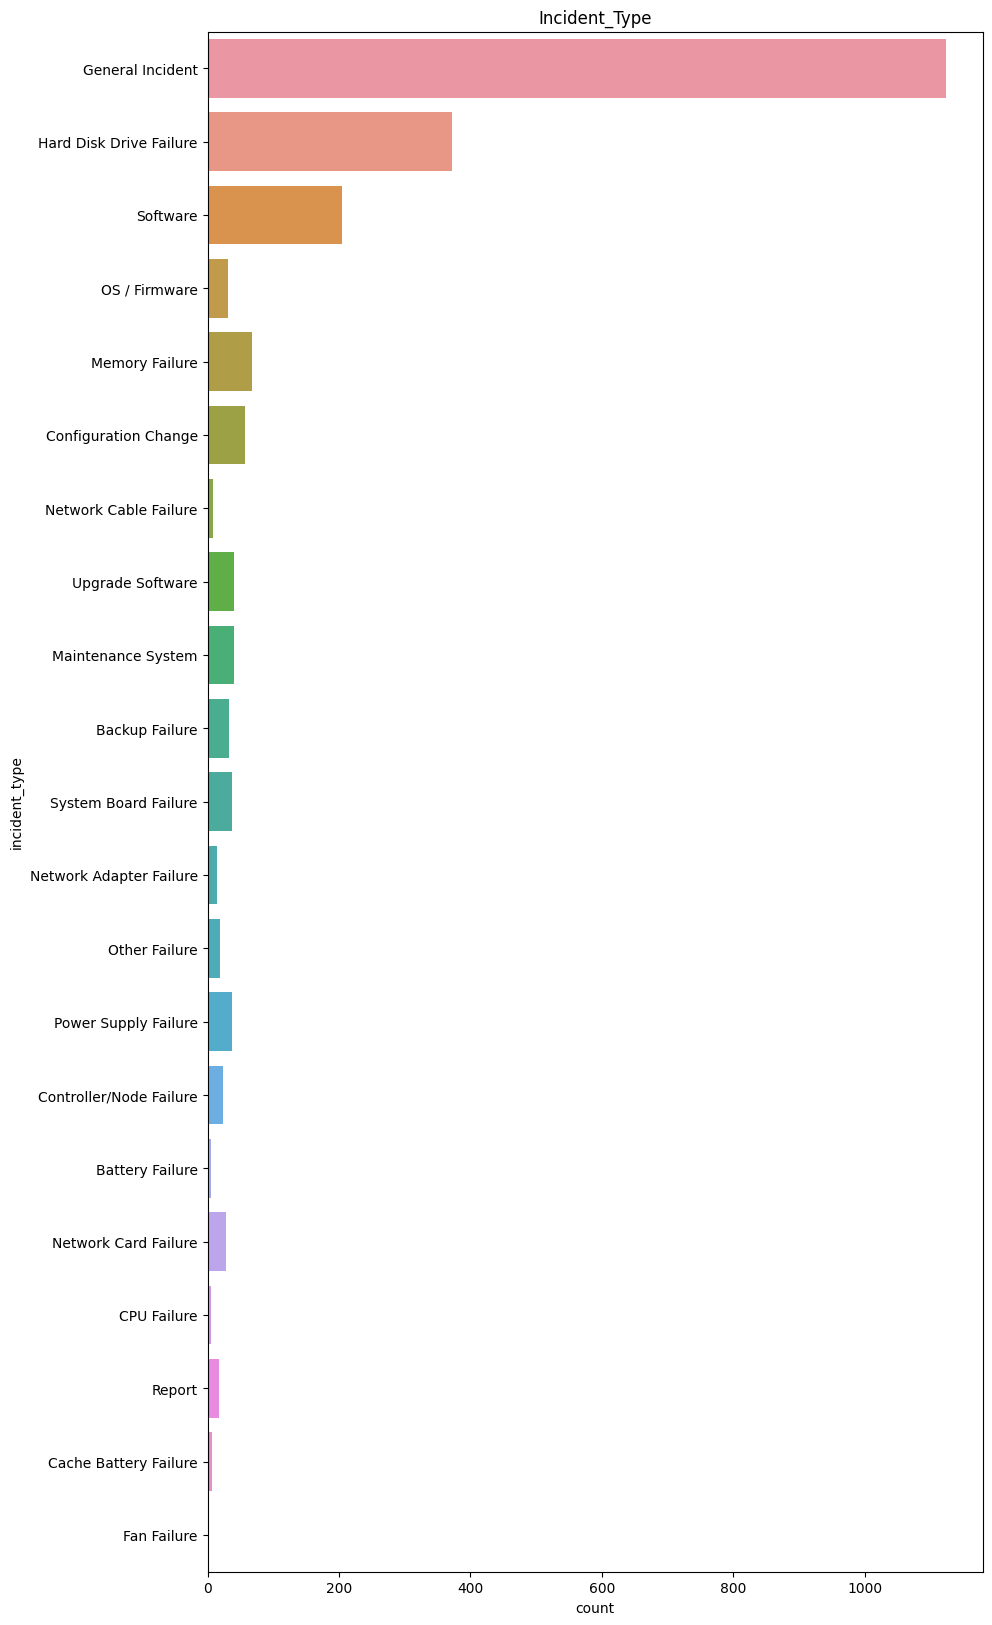

In [19]:
for col in VBar:
    fig , ax = plt.subplots(figsize=(10,20))
    ax =sns.countplot(y=col, data=df_all)
    plt.title(col.title())
    plt.show()

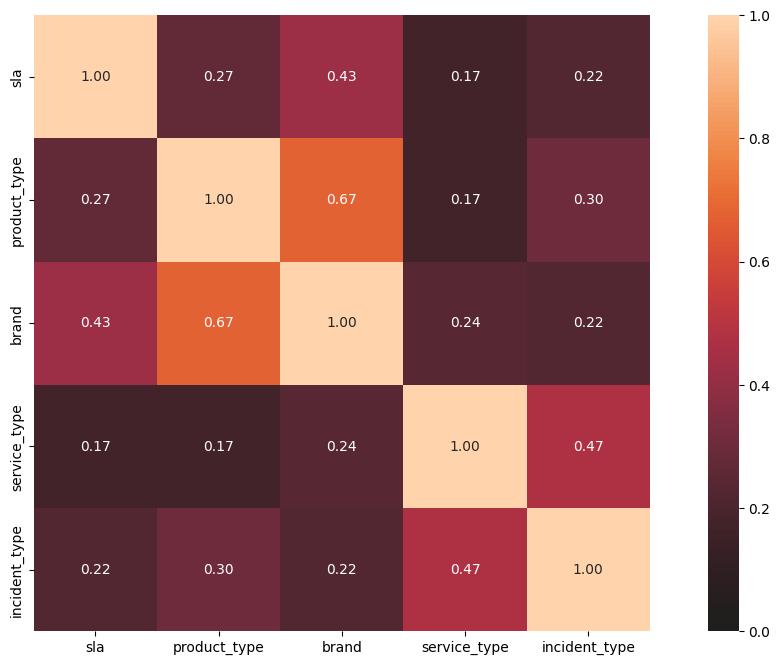

In [20]:
complete_correlation= associations(df_all[ cateCols ], figsize=(15,8))

In [21]:
print(df_all.info())
df_all.to_csv(f"data/{file_name}",index=False)
df_all.to_csv(f"{bucket_name}/{file_name}",index=False) 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2169 entries, 0 to 2320
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2169 non-null   Int64  
 1   severity_name              2169 non-null   object 
 2   sla                        2169 non-null   object 
 3   product_type               2169 non-null   object 
 4   brand                      2169 non-null   object 
 5   service_type               2169 non-null   object 
 6   incident_type              2169 non-null   object 
 7   open_to_close_hour         2169 non-null   float64
 8   response_to_resolved_hour  2169 non-null   float64
dtypes: Int64(1), float64(2), object(6)
memory usage: 171.6+ KB
None
